In [171]:
import numpy as np
import pandas as pd
from scipy.stats import norm, expon, chi2, uniform
import matplotlib.pyplot as plt
import requests
import io
import statsmodels.stats.weightstats as st
%matplotlib inline

# Foundations for statistical inference - Confidence intervals

Based on OpenIntro Labs for Python: https://github.com/vaksakalli/stats_tutorials, https://www.openintro.org/book/os/

## Sampling from King County

Let's first load the data that we already know: the official public records of all 21613 home sales from May 2014 through May 2015 in the King County area, Washington State (https://rstudio-pubs-static.s3.amazonaws.com/155304_cc51f448116744069664b35e7762999f.html). 

In [172]:
house_df = pd.read_csv('../kc_house_data.csv')

This is what we would call a "population", that is *all* home sales in that period in that area. It allows to answer questions like, "How big is the typical house sold in King County in 2014?" and "How much variation is there in sizes of houses sold in that area in that period?".

Gathering information on an entire population is often extremely costly or impossible, and so having access to it is rarely the case in real life. Because of this, we often take a *sample* of the population and use that to understand the properties of the population.

If you have access to only a sample of the population, answering the above questions becomes more complicated. What is your best guess for the typical size if you only know the sizes of several dozen houses? Guessing from samples to conclude about the population is called *inference*.

### Exercise 1
a) take a sample of N=100 random house prices, and compare histograms, means, and standard deviations of the sample and the population. Repeat it several times and observe what changes.

Population mean: 540088.1417665294
Sample mean: 501813.33
Population std: 367127.19648269983
Sample std: 293187.0928591383


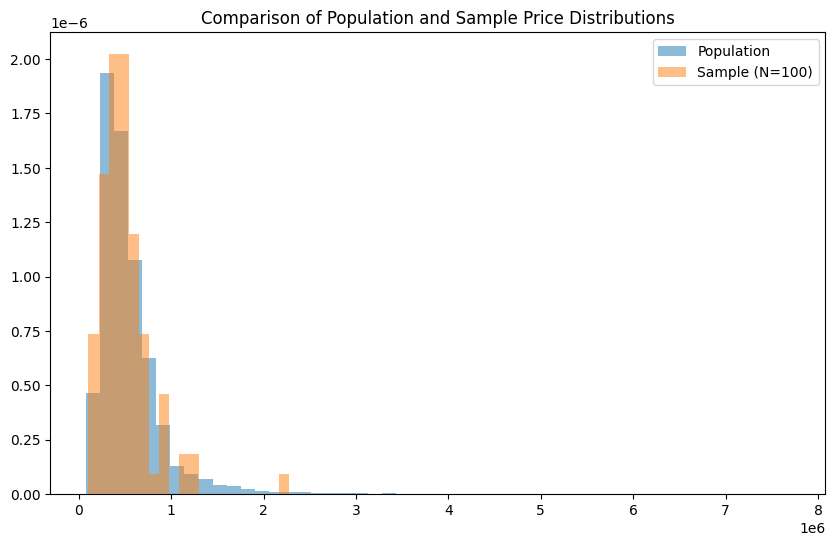

In [173]:
prices = house_df["price"]
sample_prices = prices.sample(100)

print("Population mean:", prices.mean())
print("Sample mean:", sample_prices.mean())
print("Population std:", prices.std())
print("Sample std:", sample_prices.std())

plt.figure(figsize=(10, 6))
plt.hist(prices, bins=50, alpha=0.5, label='Population', density=True)
plt.hist(sample_prices, bins=20, alpha=0.5, label='Sample (N=100)', density=True)
plt.legend()
plt.title("Comparison of Population and Sample Price Distributions")
plt.show()

Not surprisingly, every time we take another random sample, we get a different sample mean. It's useful to get a sense of just how much variability we should expect when estimating the population mean this way. The distribution of sample means, called the *sampling distribution*, can help us understand this variability. Here, because we have access to the population, we can build up the sampling distribution for the sample mean by repeating the above steps many times.

b) generate 1000 samples and compute the sample mean of each. Plot the sampling distribution against the population mean.

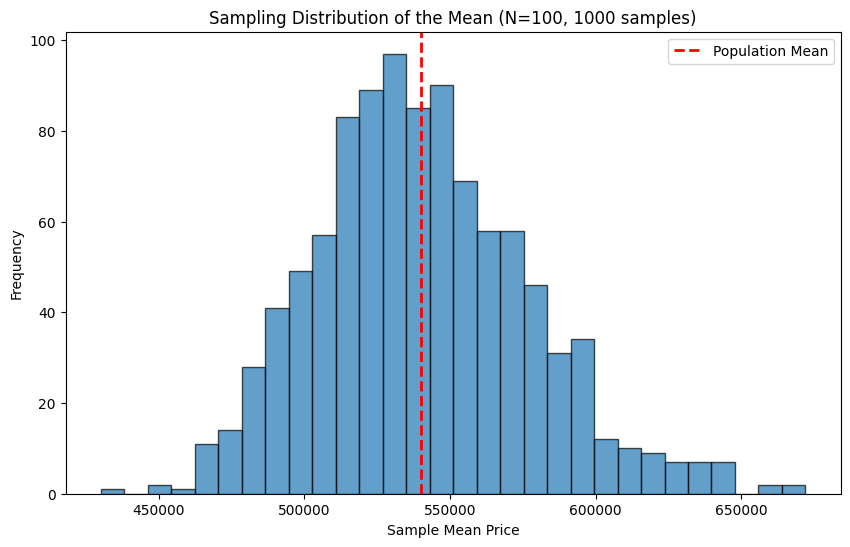

In [174]:
sample_means = [prices.sample(100).mean() for _ in range(1000)]

plt.figure(figsize=(10, 6))
plt.hist(sample_means, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(prices.mean(), color='red', linestyle='dashed', linewidth=2, label='Population Mean')
plt.title("Sampling Distribution of the Mean (N=100, 1000 samples)")
plt.xlabel("Sample Mean Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Because the sample mean is an unbiased estimator, the sampling distribution is centered at the true average living area of the the population, and the spread of the distribution indicates how much variability is induced by sampling only 100 home sales.
The standard deviation of sampling distribution is called the *standard error (SE)* of a statistic. If the parameter or the statistic is the mean, it is called the *standard error of the mean (SEM)*.

To get a sense of the effect that sample size has on our distribution, let's build up more sampling distributions:

c) build sampling distributions for $N=2, 4, 8, ..., 4096$, compute their standard deviations, plot them on logarithmic-logarithimics scale, and compare them to $1/\sqrt{N}$.

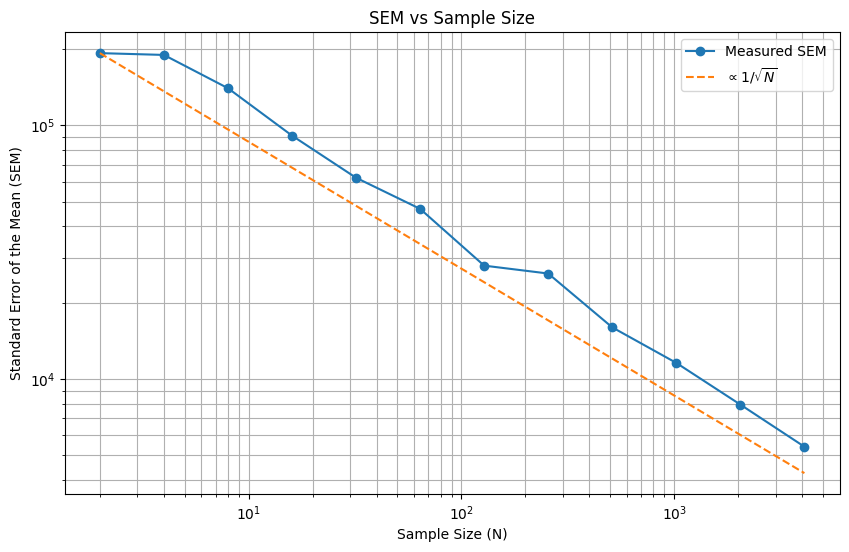

In [175]:
n_values = [2**i for i in range(1, 13)] # 2, 4, 8, ..., 4096
sample_stds = []

for n in n_values:
    means = [prices.sample(n).mean() for _ in range(100)]
    sample_stds.append(np.std(means))

plt.figure(figsize=(10, 6))
plt.loglog(n_values, sample_stds, 'o-', label='Measured SEM')
plt.loglog(n_values, sample_stds[0] * np.sqrt(n_values[0]) / np.sqrt(n_values), '--', label=r'$\propto 1/\sqrt{N}$')
plt.xlabel('Sample Size (N)')
plt.ylabel('Standard Error of the Mean (SEM)')
plt.title('SEM vs Sample Size')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.show()

As expected (https://en.wikipedia.org/wiki/Standard_error#Standard_error_of_the_mean) SEM behaves like $\propto 1/\sqrt{N}$, which means that the larger sample you have, the more precise estimate of the population mean you can derive.

## Confidence intervals
One of the most common ways to describe the typical or central value of a distribution is to use *point estimate*, i.e., a single plausible value for a parameter, e.g., the sample mean (usually denoted as $\bar{x}$). However, usually there is some error in the estimate. In addition to supplying a point estimate of a parameter, a next logical step would be to provide a plausible range of values, in our case a *confidence interval*.

After setting the *confidence level* (the probability that the parameter lies in a given interval), usually 95%, we can compute the confidence interval (CI) for the sample mean.
If the sampling distribution is normally distributed one can do it by adding and subtracting 1.96 standard errors to the point estimate: $\bar{x}\pm 1.96\times SE$.

In [176]:
sample_prices = prices.sample(100)
sample_mean=sample_prices.mean()
se = np.std(sample_prices)/np.sqrt(100)
lower = sample_mean - (1.96 * se)
upper = sample_mean + (1.96 * se)
print(lower, upper)

477448.3804937851 607190.619506215


This is an important inference that we've just made: even though we don't know what the full population looks like, we're 95% confident that the true average price of houses sold in Kings County lies between the values `lower` and `upper`. There are a few conditions that must be met for this interval to be valid.

## Exercise 2
a) generate a normal distribution with the mean and standard deviation equal to the ones from the price distribution.
Compute the probability (use *cumulative distribution function*, `cdf`) of the random variable lying inside the interval $[\mu-1.96\times \sigma,\mu+1.96\times \sigma]$ (where $\mu$ and $\sigma$ are population parameters).
Plot it.
Compute a 99% confidence interval (use `interval`).

Probability of X lying in [μ-1.96σ, μ+1.96σ]: 0.9500


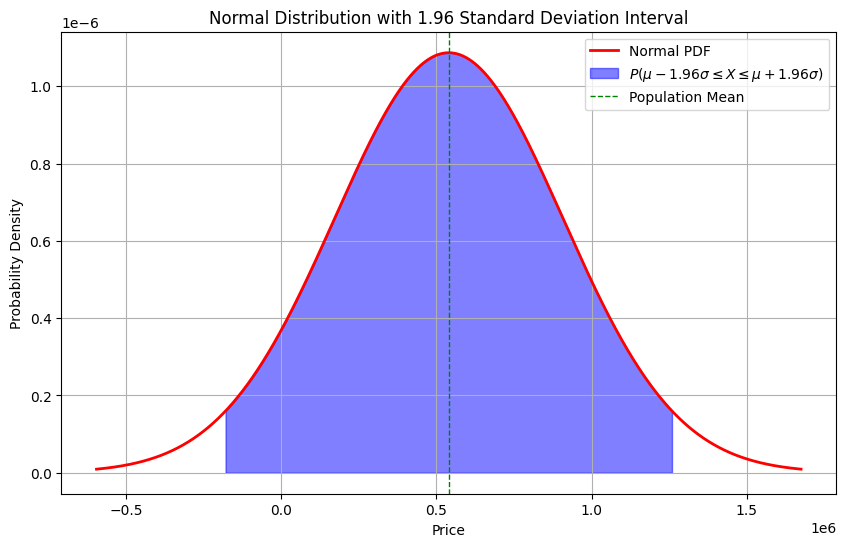

99% Confidence Interval: (np.float64(-405568.8490633636), np.float64(1485745.1325964225))


In [177]:

population_mean = prices.mean()
population_std = prices.std()

rv_norm_population = norm(loc=population_mean, scale=population_std)

# Compute the probability for the interval [mu - 1.96*sigma, mu + 1.96*sigma]
lower_bound_prob = population_mean - (1.96 * population_std)
upper_bound_prob = population_mean + (1.96 * population_std)
probability_in_interval = rv_norm_population.cdf(upper_bound_prob) - rv_norm_population.cdf(lower_bound_prob)
print(f"Probability of X lying in [μ-1.96σ, μ+1.96σ]: {probability_in_interval:.4f}")

# Plot the distribution and highlight the interval
x = np.linspace(rv_norm_population.ppf(0.001), rv_norm_population.ppf(0.999), 1000)
plt.figure(figsize=(10, 6))
plt.plot(x, rv_norm_population.pdf(x), 'r-', lw=2, label='Normal PDF')
plt.fill_between(x, 0, rv_norm_population.pdf(x), where=(x >= lower_bound_prob) & (x <= upper_bound_prob), color='blue', alpha=0.5, label=r'$P(\mu-1.96\sigma \leq X \leq \mu+1.96\sigma)$')
plt.axvline(population_mean, color='green', linestyle='dashed', linewidth=1, label='Population Mean')
plt.title('Normal Distribution with 1.96 Standard Deviation Interval')
plt.xlabel('Price')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

# Compute a 99% confidence interval
conf_interval_99 = rv_norm_population.interval(0.99)
print(f"99% Confidence Interval: {conf_interval_99}")


b) generate a sample of $N=10 000$ normally distributed random numbers with the mean and standard deviation equal to the ones from the price distribution.
Compute the mean and standard deviation of such a sample.
Compute what percentage of numbers lie outside of the interval: $[\bar{x}-1.96\times SD,\bar{x}+1.96\times SD]$.

In [178]:
N_sample = 10000
np_sample = np.random.normal(loc=population_mean, scale=population_std, size=N_sample)

# Compute the mean and standard deviation of such a sample
sample_mean_ex2b = np_sample.mean()
sample_std_ex2b = np_sample.std()
print(f"Sample mean (N={N_sample}): {sample_mean_ex2b:.2f}")
print(f"Sample standard deviation (N={N_sample}): {sample_std_ex2b:.2f}")

# Compute what percentage of numbers lie outside of the interval: [x̄-1.96*SD, x̄+1.96*SD]
lower_bound_ex2b = sample_mean_ex2b - (1.96 * sample_std_ex2b)
upper_bound_ex2b = sample_mean_ex2b + (1.96 * sample_std_ex2b)

outside_interval_count = np.sum((np_sample < lower_bound_ex2b) | (np_sample > upper_bound_ex2b))
percentage_outside_interval = (outside_interval_count / N_sample) * 100
print(f"Percentage of numbers outside [x̄-1.96*SD, x̄+1.96*SD]: {percentage_outside_interval:.2f}%")


Sample mean (N=10000): 545091.95
Sample standard deviation (N=10000): 365647.99
Percentage of numbers outside [x̄-1.96*SD, x̄+1.96*SD]: 4.86%


c) take $N=1000$ samples of size $n=50$ from the data prices.
For each sample compute mean, SEM and a confidence interval. Check if the *true population mean* lies within or without the CI.
What is the percentage of instances that the true mean what not in the CI?

In [179]:
N_samples = 1000
sample_size = 50

population_mean = prices.mean()

outside_ci_count = 0

for _ in range(N_samples):
    sample = prices.sample(sample_size)
    sample_mean = sample.mean()
    sample_std = sample.std()
    se = sample_std / np.sqrt(sample_size)
    
    lower_bound_ci = sample_mean - (1.96 * se)
    upper_bound_ci = sample_mean + (1.96 * se)
    
    if not (lower_bound_ci <= population_mean <= upper_bound_ci):
        outside_ci_count += 1
        
percentage_outside_ci = (outside_ci_count / N_samples) * 100
print(f"Percentage of instances where the true mean was not in the CI: {percentage_outside_ci:.2f}%")


Percentage of instances where the true mean was not in the CI: 7.90%


Now, look again at the result Ex.2b and the meaning of confidence level.
A 95% confidence level does not state that for a given realized interval there is a 95% probability that the population parameter lies within the interval (i.e., a 95% probability that the interval covers the population parameter).
The confidence level states that 95% of randomly chosen samples produce confidence interval that cover the population parameter, and 5% of samples have CIs that do not cover the true value.

For reference, see: https://en.wikipedia.org/wiki/Confidence_interval#Meaning_and_interpretation

# Inference for numerical data
## North Carolina births
In 2004, the state of North Carolina released a large data set containing information on births recorded in this state. This data set is useful to researchers studying the relation between habits and practices of expectant mothers and the birth of their children. We will work with a random sample of observations from this data set.

Load the `nc` data set into our notebook.

In [180]:
nc = pd.read_csv('../nc.csv')

display(nc.head())

,fage,mage,mature,weeks,premie,visits,marital,gained,weight,lowbirthweight,gender,habit,whitemom
0,NaN,13,younger mom,39.0,full term,10.0,married,38.0,7.63,not low,male,nonsmoker,not white
1,NaN,14,younger mom,42.0,full term,15.0,married,20.0,7.88,not low,male,nonsmoker,not white
2,19.0,15,younger mom,37.0,full term,11.0,married,38.0,6.63,not low,female,nonsmoker,white
3,21.0,15,younger mom,41.0,full term,6.0,married,34.0,8.00,not low,male,nonsmoker,white
4,NaN,15,younger mom,39.0,full term,9.0,married,27.0,6.38,not low,female,nonsmoker,not white


We have observations on 13 different variables, some categorical and some numerical. The meaning of each variable is as follows.

| variable         | description |
| ---------------- | ------------|
| `fage`           | father's age in years. |
| `mage`           | mother's age in years. |
| `mature`         | maturity status of mother. |
| `weeks`          | length of pregnancy in weeks. |
| `premie`         | whether the birth was classified as premature (premie) or full-term. |
| `visits`         | number of hospital visits during pregnancy. |
| `marital`        | whether mother is `married` or `not married` at birth. |
| `gained`         | weight gained by mother during pregnancy in pounds. |
| `weight`         | weight of the baby at birth in pounds. |
| `lowbirthweight` | whether baby was classified as low birthweight (`low`) or not (`not low`). |
| `gender`         | gender of the baby, `female` or `male`. |
| `habit`          | status of the mother as a `nonsmoker` or a `smoker`. |
| `whitemom`       | whether mom is `white` or `not white`. |

## Exercise 3
Consider the possible relationship between a mother's smoking habit and the weight of her baby.

a) plot histograms of baby weights for smoker and non-smoker mothers. Compute means of these two groups (use `groupby`).

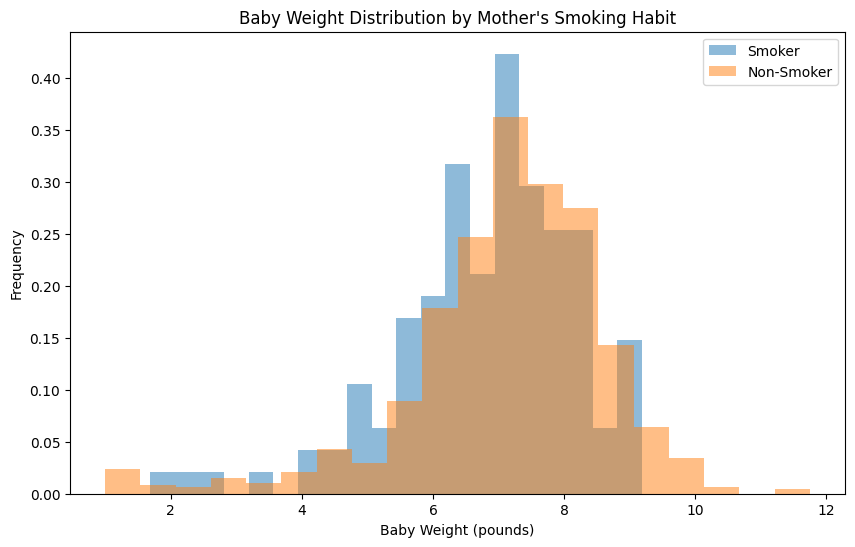

Mean weight for smoker mothers: 6.83
Mean weight for non-smoker mothers: 7.14


In [181]:
nc_weightANDsmoker = nc[nc['habit'] == 'smoker']['weight']
nc_weightANDnonsmoker = nc[nc['habit'] == 'nonsmoker']['weight']

plt.figure(figsize=(10, 6))
plt.hist(nc_weightANDsmoker, bins=20, alpha=0.5, label='Smoker', density=True)
plt.hist(nc_weightANDnonsmoker, bins=20, alpha=0.5, label='Non-Smoker', density=True)
plt.legend()
plt.title('Baby Weight Distribution by Mother\'s Smoking Habit')
plt.xlabel('Baby Weight (pounds)')
plt.ylabel('Frequency')
plt.show()

print(f"Mean weight for smoker mothers: {nc_weightANDsmoker.mean():.2f}")
print(f"Mean weight for non-smoker mothers: {nc_weightANDnonsmoker.mean():.2f}")


We will now conduct hypothesis tests for testing if the average weights of babies born to smoking and non-smoking mothers are different. For this task, we can use [`statsmodels`](https://www.statsmodels.org/stable/index.html), a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration.

b) use `DescrStatsW` to compute means and sample sizes. Then use `CompareMeans` to perform a t-test for difference between the two means, compute CI of the difference and find the p-value. Assuming we set a significance level of 0.05 to reach any conclusion, what is the verdict?

In [182]:

dsw1 = st.DescrStatsW(nc_weightANDsmoker)
dsw2 = st.DescrStatsW(nc_weightANDnonsmoker)

# Compare Means
cm = st.CompareMeans(dsw1, dsw2)
z_stat, p_val = cm.ztest_ind(usevar='unequal') # 'unequal' for Welch's T-test if variances differ

print(f"Z-test Statistic: {z_stat:.4f}")
print(f"Z-test P-value: {p_val:.4f}")

# Confidence Interval
lower, upper = cm.tconfint_diff(usevar='unequal')
print(f"95% Confidence Interval for difference: ({lower:.4f}, {upper:.4f})")

alpha = 0.05

print(f"Test Result: {'Significant' if p_val < alpha else 'Not Significant'}")

if p_val > alpha:
    print("Verdict: We fail to reject the null hypothesis.")
    print("Conclusion: There is no statistically significant difference in baby weights between smokers and non-smokers.")
else:
    print("Verdict: Reject the null hypothesis.")
    print("Conclusion: There is a statistically significant difference in weights.")

Z-test Statistic: -2.3590
Z-test P-value: 0.0183
95% Confidence Interval for difference: (-0.5796, -0.0515)
Test Result: Significant
Verdict: Reject the null hypothesis.
Conclusion: There is a statistically significant difference in weights.


c) the caveat is that we have not checked t-test assumptions: normality and equal variances of the two samples.
Let's use Shapiro-Wilk for the former, and Levene test for the latter.
And since the assumptions of Student's t-test will turn out to be not fulfilled, let's use Mann-Whitney's U test to compare the two groups.

In [183]:
from scipy.stats import shapiro, levene, mannwhitneyu

# Testing normality for smokers
stat_s, p_s = shapiro(nc_weightANDsmoker)
# Testing normality for non-smokers
stat_ns, p_ns = shapiro(nc_weightANDnonsmoker)

print(f"Shapiro P-value (Smoker): {p_s}")
print(f"Shapiro P-value (Non-Smoker): {p_ns}")

stat_l, p_l = levene(nc_weightANDsmoker, nc_weightANDnonsmoker)

print(f"Levene's Test P-value: {p_l:.4f}")

if p_l < 0.05:
    print("Variances are significantly different.")
else:
    print("Variances are equal.")

Shapiro P-value (Smoker): 5.5275473316848716e-05
Shapiro P-value (Non-Smoker): 2.6290535159288003e-20
Levene's Test P-value: 0.6098
Variances are equal.


Which means you'd better quit smoking.